In [1]:
import os
import numpy as np
import rasterio
import geopandas as gpd
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from rasterio.warp import reproject, Resampling
from rasterio.transform import rowcol
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from rasterstats import zonal_stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from skimage.util import img_as_float
from rasterio import features
from rasterio.features import shapes
from shapely.geometry import shape

In [2]:
# setup workspace 
base_dir = r"C:\Users\Ethel Ogallo\Documents\ZFL1\Data\Regression datasets"
features_dir = os.path.join(base_dir, "features")

# static rasters (similar for each year)
static_files = [
    os.path.join(features_dir, "distance_to_water_meters.tif"),
    os.path.join(features_dir, "relativeDEM.tif"),
    os.path.join(features_dir, "TWI.tif"),
]

# set-up reference
relative_dem_path = os.path.join(features_dir, "relativeDEM.tif")
if not os.path.exists(relative_dem_path):
    raise FileNotFoundError(f"relativeDEM not found: {relative_dem_path}")

with rasterio.open(relative_dem_path) as ref:
    ref_shape = ref.shape
    ref_transform = ref.transform
    ref_crs = ref.crs

print(f"Using relativeDEM as reference: {ref_crs}")

Using relativeDEM as reference: EPSG:32637


In [3]:
### function to load and reproject raster files 
def load_and_reproject_raster(path, ref_crs, ref_transform, shape):
    try:
        with rasterio.open(path) as src:
            dst_array = np.full(shape, np.nan, dtype=np.float32)
            reproject(
                source=rasterio.band(src, 1),
                destination=dst_array,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=ref_transform,
                dst_crs=ref_crs,
                resampling=Resampling.nearest,
                src_nodata=src.nodata,
                dst_nodata=np.nan
            )
        return dst_array
    except Exception as e:
        print(f"Failed to load {path}: {e}")
        return None

### Stack rasters
for year in sorted(os.listdir(features_dir)):
    year_path = os.path.join(features_dir, year)
    if not os.path.isdir(year_path):
        continue  # skip static files at root level
    
    print(f"\nProcessing year: {year}")

    # collect year-specific rasters
    temporal_files = [
        os.path.join(year_path, f)
        for f in os.listdir(year_path)
        if f.lower().endswith(".tif")
    ]

    if not temporal_files:
        print(f"No temporal rasters found for {year}, skipping.")
        continue

    # final list: static + temporal
    feature_files = static_files + temporal_files

    layers, layer_names = [], []
    for path in feature_files:
        arr = load_and_reproject_raster(path, ref_crs, ref_transform, ref_shape)
        if arr is not None:
            layers.append(arr)
            layer_names.append(os.path.splitext(os.path.basename(path))[0])

    stack = np.stack(layers, axis=-1)
    print(f"Stacked {len(layers)} layers for {year}. Final shape: {stack.shape}")

    # save raster
    output_path = os.path.join(year_path, f"feature_stack_{year}.tif")
    nodata_value = np.nan
    height, width, n_layers = stack.shape

    with rasterio.open(
        output_path,
        "w",
        driver="GTiff",
        height=height,
        width=width,
        count=n_layers,
        dtype=stack.dtype,
        crs=ref_crs,
        transform=ref_transform,
        nodata=nodata_value
    ) as dst:
        for i in range(n_layers):
            band_data = stack[:, :, i]
            dst.write(band_data, i + 1)
            dst.set_band_description(i + 1, layer_names[i])

    print(f"Feature stack saved: {output_path}")

    # confirm
    with rasterio.open(output_path) as src:
        print("Bands:", src.count)
        print("Descriptions:", src.descriptions)


Processing year: 2024
Stacked 18 layers for 2024. Final shape: (2215, 1118, 18)
Feature stack saved: C:\Users\Ethel Ogallo\Documents\ZFL1\Data\Regression datasets\features\2024\feature_stack_2024.tif
Bands: 18
Descriptions: ('distance_to_water_meters', 'relativeDEM', 'TWI', 'BSI_Max_2024', 'BSI_Min_2024', 'BSI_SD_2024', 'BSI_TE_2024', 'EVI_Median_2024', 'feature_stack_2024', 'inundation_frequency_2024', 'NDVI_Max_2024', 'NDVI_Min_2024', 'NDVI_SD_2024', 'NDVI_TE_2024', 'NDWI_Max_2024', 'NDWI_Min_2024', 'NDWI_SD_2024', 'NDWI_TE_2024')


In [ ]:
# --- Raster loading utilities ---
def load_multiband_raster(path):
    with rasterio.open(path) as src:
        data = src.read()
        transform = src.transform
        crs = src.crs
        profile = src.profile
    return data, transform, crs, profile

def load_raster(path):
    with rasterio.open(path) as src:
        data = src.read(1)
        transform = src.transform
        crs = src.crs
        profile = src.profile
    return data, transform, crs, profile

In [5]:
def process_year(year, base_dir):
    print(f"\n=== Processing {year} ===")

    # --- Paths ---
    planet_path = os.path.join(base_dir, year, f"planet_masked_8b_{year}.tif")
    feature_stack_path = os.path.join(base_dir, "features", year, f"feature_stack_{year}.tif")
    ecog_segmentation_path = os.path.join(base_dir, year, f"ecog_segmentation_{year}.shp")
    segmentation_raster_path = os.path.join(base_dir, year, f"segmentation_{year}.tif")
    polygon_shp_path = os.path.join(base_dir, year, f"segments_{year}.shp")

    # --- 1. Load Planet image ---
    if os.path.exists(planet_path):
        planet_image_stack, _, _, planet_profile = load_multiband_raster(planet_path)
        print(f"Planet imagery loaded: {planet_image_stack.shape} (bands, height, width)")
    else:
        print(f"Planet imagery not found for {year}: {planet_path}")
        return

    # --- 2. Rasterize segmentation shapefile ---
    def load_ecognition_segments(shapefile_path, reference_raster_path, id_field=None):
        # Load your reference raster (feature stack)
        with rasterio.open(reference_raster_path) as src:
            transform = src.transform
            crs = src.crs
            out_shape = (src.height, src.width)

        # Load polygons and reproject to raster CRS
        gdf = gpd.read_file(shapefile_path).to_crs(crs)

        # Create segment IDs if id_field not provided
        if id_field is None:
            gdf["segment_id"] = np.arange(1, len(gdf) + 1)
            id_field = "segment_id"

        # Rasterize polygons to the raster grid
        segment_raster = features.rasterize(
            ((geom, value) for geom, value in zip(gdf.geometry, gdf[id_field])),
            out_shape=out_shape,
            transform=transform,
            fill=0,
            dtype="int32"
        )

        return segment_raster, transform, crs
    
    def save_raster(array, transform, crs, out_path, dtype='int32'):
        height, width = array.shape
        with rasterio.open(
            out_path,
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=1,
            dtype=dtype,
            crs=crs,
            transform=transform,
            compress='lzw'
        ) as dst:
            dst.write(array, 1)
    
    if os.path.exists(ecog_segmentation_path) and os.path.exists(feature_stack_path):
        segments, transform, crs = load_ecognition_segments(
            ecog_segmentation_path,
            feature_stack_path
        )
        print("Segmentation raster shape:", segments.shape)
        print("Unique segment IDs:", len(np.unique(segments)) - 1)

        # Save segmentation raster
        save_raster(segments, transform, crs, segmentation_raster_path)
    else:
        print(f"Missing input files for segmentation in {year}")
        return

    # --- 3. Polygonize segmentation raster ---
    with rasterio.open(segmentation_raster_path) as seg_src:
        segments = seg_src.read(1)
        seg_transform = seg_src.transform
        seg_crs = seg_src.crs

    def polygonize_segments(segments_raster, transform, crs):
        mask = segments_raster != 0
        results = (
            {
                "type": "Feature",
                "geometry": shape(geom),
                "properties": {"segment_id": int(value)}
            }
            for geom, value in shapes(segments_raster, mask=mask, transform=transform)
        )
        return gpd.GeoDataFrame.from_features(results, crs=crs)

    gdf_segments = polygonize_segments(segments, seg_transform, seg_crs)
    gdf_segments.to_file(polygon_shp_path)
    print(f"Polygonized segments saved to: {polygon_shp_path}")

    print(f"Finished processing {year}")


In [6]:
# Run for one year
process_year("2024", base_dir)


=== Processing 2024 ===
Planet imagery loaded: (8, 17773, 13174) (bands, height, width)
Segmentation raster shape: (2215, 1118)
Unique segment IDs: 24830
Polygonized segments saved to: C:\Users\Ethel Ogallo\Documents\ZFL1\Data\Regression datasets\2024\segments_2024.shp
Finished processing 2024


##### feature extraction and labeling  
run zonal_stats.py  
Chnage variable year in zonal_stats.py before running in vm

#### Classification - ecognition segments

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def train_classifier(year, base_dir, n_estimators=500):
    """Train and evaluate Random Forest on labeled segment features for a given year."""
    seg_csv = os.path.join(base_dir, year, f"segments_features_{year}.csv")

    if not os.path.exists(seg_csv):
        raise FileNotFoundError(f"Missing zonal stats CSV: {seg_csv}")

    df_segments = pd.read_csv(seg_csv)

    # Features (exclude ID and class column)
    band_names = [c for c in df_segments.columns if c not in ['segment_id', 'class']]

    # Drop unlabeled segments
    df_labeled = df_segments.dropna(subset=['class']).copy()
    X = df_labeled[band_names].values
    y = df_labeled['class'].values

    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1)

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(rf, X, y, cv=cv, scoring='accuracy')
    print(f"\n=== {year} Training Results ===")
    print(f"CV Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix ({year})")
    plt.show()

    print(classification_report(y_test, y_pred))

    # Feature importance
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(8, 6))
    plt.barh(np.array(band_names)[indices], importances[indices], color='steelblue')
    plt.gca().invert_yaxis()
    plt.title(f"Feature Importance ({year})")
    plt.tight_layout()
    plt.show()

    return rf, band_names



=== 2024 Training Results ===
CV Accuracy: 0.887 ± 0.013


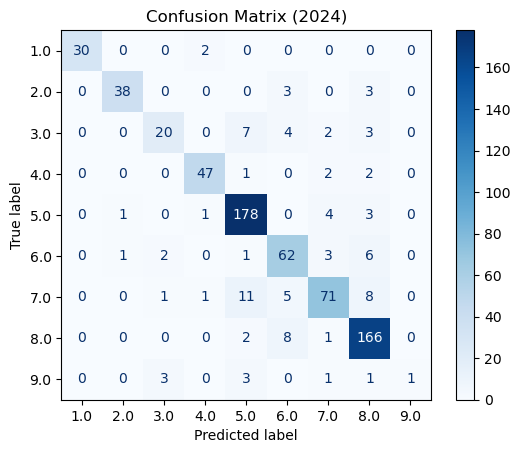

              precision    recall  f1-score   support

         1.0       1.00      0.94      0.97        32
         2.0       0.95      0.86      0.90        44
         3.0       0.77      0.56      0.65        36
         4.0       0.92      0.90      0.91        52
         5.0       0.88      0.95      0.91       187
         6.0       0.76      0.83      0.79        75
         7.0       0.85      0.73      0.78        97
         8.0       0.86      0.94      0.90       177
         9.0       1.00      0.11      0.20         9

    accuracy                           0.86       709
   macro avg       0.89      0.76      0.78       709
weighted avg       0.87      0.86      0.86       709



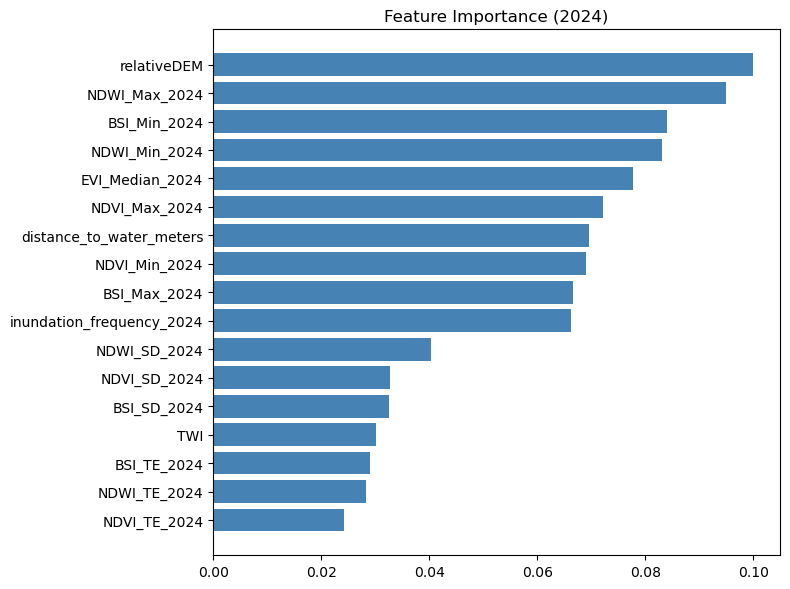

In [18]:
# Train on 2024
rf_model, features = train_classifier("2024", base_dir)

In [19]:
def predict_segments(year, base_dir, rf_model=None, n_estimators=500):
    """Predict classes for all segments and save classification raster."""
    seg_csv = os.path.join(base_dir, year, f"segments_features_{year}.csv")
    seg_raster_path = os.path.join(base_dir, year, f"segmentation_{year}.tif")
    out_class_raster = os.path.join(base_dir, year, f"rf_classification_{year}.tif")

    if not os.path.exists(seg_csv) or not os.path.exists(seg_raster_path):
        raise FileNotFoundError("Missing inputs for prediction")

    df_segments = pd.read_csv(seg_csv)
    band_names = [c for c in df_segments.columns if c not in ['segment_id', 'class']]

    # Handle NaNs
    X_all = df_segments[band_names].copy()
    for col in band_names:
        X_all[col] = X_all[col].fillna(X_all[col].mean())

    # Train model on all labeled data if no model provided
    if rf_model is None:
        print(f"No model passed, training new one on all labeled data for {year}")
        mask_labeled = df_segments['class'].notna()
        rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1)
        rf_model.fit(X_all[mask_labeled], df_segments.loc[mask_labeled, 'class'])

    # Predict
    pred_all = rf_model.predict(X_all)
    df_segments['pred_class'] = pred_all

    # Map predictions to raster
    with rasterio.open(seg_raster_path) as src:
        seg_array = src.read(1)
        meta = src.meta.copy()

    seg_to_class = dict(zip(df_segments['segment_id'], df_segments['pred_class']))
    pred_raster = np.zeros_like(seg_array, dtype=np.int32)
    for seg_id, cls in seg_to_class.items():
        pred_raster[seg_array == seg_id] = cls

    # Save raster
    meta.update({'dtype': 'int32', 'count': 1})
    with rasterio.open(out_class_raster, 'w', **meta) as dst:
        dst.write(pred_raster, 1)

    print(f"Saved classification raster: {out_class_raster}")
    return out_class_raster

In [20]:
# Predict using that trained model
predict_segments("2024", base_dir, rf_model)

c:\Users\Ethel Ogallo\anaconda3\envs\zfl_wetland\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Saved classification raster: C:\Users\Ethel Ogallo\Documents\ZFL1\Data\Regression datasets\2024\rf_classification_2024.tif


'C:\\Users\\Ethel Ogallo\\Documents\\ZFL1\\Data\\Regression datasets\\2024\\rf_classification_2024.tif'

In [21]:
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_classification_map(year, base_dir):
    """Load and plot classification raster with custom colormap + legend."""
    
    # --- Class mapping ---
    class_names = [
        "Permanent Frshwater Lakes",
        "Permanent marshes",
        "Rivers",
        "Peatlands",
        "Seasonal flood plain",
        "Tree-dominated Wetland",
        "Shrub-dominated Wetland",
        "Agricultural",
        "Ponds"
    ]

    # Colors for each class (index 1..N)
    colors = [
        "#1f78b4",  # Permanent Frshwater Lakes
        "#33a02c",  # Permanent marshes
        "#a6cee3",  # Rivers
        "#ff7f00",  # Peatlands
        "#fdbf6f",  # Seasonal flood plain
        "#6a3d9a",  # Tree-dominated Wetland
        "#cab2d6",  # Shrub-dominated Wetland
        "#ffff99",  # Agricultural
        "#e31a1c"   # Ponds
    ]

    raster_path = os.path.join(base_dir, year, f"rf_classification_{year}.tif")
    if not os.path.exists(raster_path):
        raise FileNotFoundError(f"Classification raster not found: {raster_path}")

    # --- Load raster ---
    with rasterio.open(raster_path) as src:
        pred_raster = src.read(1)

    # Mask no-data (0)
    nodata_value = 0
    pred_raster_masked = np.ma.masked_where(pred_raster == nodata_value, pred_raster)

    # Add no-data color
    colors_with_nodata = ["white"] + colors
    cmap = ListedColormap(colors_with_nodata)

    # Bounds include no-data at 0
    bounds = np.arange(0, len(class_names) + 2)  # 0..10
    norm = BoundaryNorm(bounds, cmap.N)

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(pred_raster_masked, cmap=cmap, norm=norm)

    # Colorbar (skip no-data)
    cbar = plt.colorbar(im, ax=ax, ticks=np.arange(1.5, len(class_names) + 1.5))
    cbar.ax.set_yticklabels(class_names)
    cbar.set_label("Classes", rotation=270, labelpad=20)

    ax.set_title(f"Wetland Types Classification ({year})")
    ax.axis("off")
    plt.show()


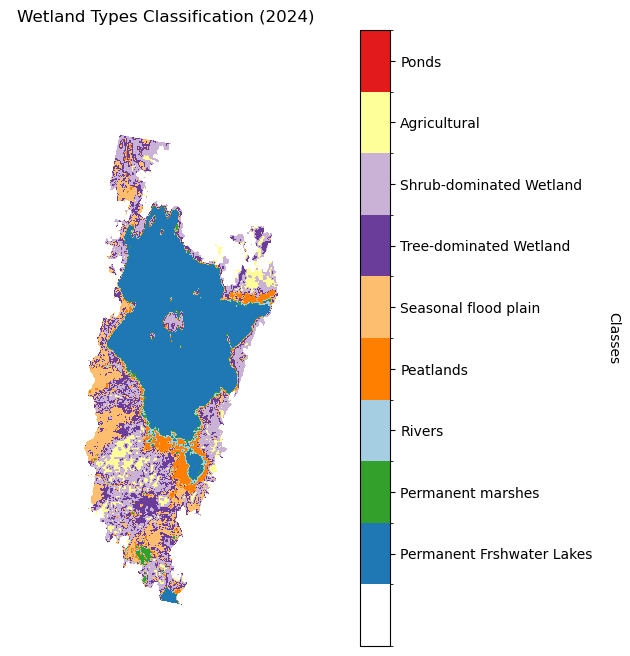

In [22]:
# Plot classification for 2024
plot_classification_map("2024", base_dir)

## plot multiple years

In [ ]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import math

def plot_classification_maps(years, base_dir, n_rows=2):
    """Plot classification rasters for multiple years in multiple rows, each with its own colorbar."""
    
    class_names = [
        "Permanent Freshwater Lakes",
        "Permanent marshes",
        "Rivers",
        "Peatlands",
        "Seasonal flood plain",
        "Tree-dominated Wetland",
        "Shrub-dominated Wetland",
        "Agricultural",
        "Ponds"
    ]
    
    colors = [
        "#1f78b4",  # Permanent Freshwater Lakes
        "#33a02c",  # Permanent marshes
        "#a6cee3",  # Rivers
        "#ff7f00",  # Peatlands
        "#6a3d9a",  # Seasonal flood plain
        "#2c5b20",  # Tree-dominated Wetland
        "#b2df8a",  # Shrub-dominated Wetland
        "#fdbf6f",  # Agricultural
        "#e31a1c"   # Ponds
    ]
    
    colors_with_nodata = ["white"] + colors
    cmap = ListedColormap(colors_with_nodata)
    bounds = np.arange(0, len(class_names) + 2)
    norm = BoundaryNorm(bounds, cmap.N)
    
    n_years = len(years)
    n_cols = math.ceil(n_years / n_rows)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 6*n_rows))
    axes = axes.flatten()
    
    for i, (ax, year) in enumerate(zip(axes, years)):
        raster_path = os.path.join(base_dir, "Output", "RF", f"rf_classification_{year}.tif")
        if not os.path.exists(raster_path):
            raise FileNotFoundError(f"Classification raster not found: {raster_path}")
        
        with rasterio.open(raster_path) as src:
            pred_raster = src.read(1)
        
        pred_raster_masked = np.ma.masked_where(pred_raster == 0, pred_raster)
        im = ax.imshow(pred_raster_masked, cmap=cmap, norm=norm)
        ax.set_title(f"{year}")
        ax.axis("off")
        
        # Individual colorbar
        cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04,
                            ticks=np.arange(1.5, len(class_names)+1.5))
        cbar.ax.set_yticklabels(class_names)
        cbar.set_label("Classes", rotation=270, labelpad=15)
    
    # Hide any extra axes if total plots < n_rows*n_cols
    for ax in axes[n_years:]:
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()
